In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time

In [2]:
# read metadata
path = "/media/SSD2/Dataset/GF3300"

demo_data = pd.read_csv(os.path.join(path, "data_summary.csv"))
demo_data

,filename,age,gender,race,ethnicity,language,maritalstatus,glaucoma,use
0,data_0001.npz,43.31,male,asian,non-hispanic,english,single,no,training
1,data_0002.npz,18.02,female,white,non-hispanic,english,single,yes,training
2,data_0003.npz,66.42,male,black,non-hispanic,english,single,yes,training
3,data_0004.npz,70.64,male,white,non-hispanic,english,single,no,training
4,data_0005.npz,71.42,female,asian,non-hispanic,english,married or partnered,yes,training
...,...,...,...,...,...,...,...,...,...
3295,data_3296.npz,49.67,male,asian,non-hispanic,english,married or partnered,no,test
3296,data_3297.npz,44.08,female,asian,non-hispanic,english,single,no,test
3297,data_3298.npz,33.90,female,asian,non-hispanic,english,married or partnered,no,test
3298,data_3299.npz,52.67,male,asian,non-hispanic,english,married or partnered,no,test


In [3]:
# demo_data = demo_data.assign(path=lambda x: f"{str(x['use']).capitalize()}/slo_fundus_{str(x['filename'])[5:10]}.jpg")
demo_data["path"] = demo_data.apply(
    lambda x: f"{str(x['use']).capitalize()}/{str(x['filename'])}", axis=1)
demo_data

,filename,age,gender,race,ethnicity,language,maritalstatus,glaucoma,use,path
0,data_0001.npz,43.31,male,asian,non-hispanic,english,single,no,training,Training/data_0001.npz
1,data_0002.npz,18.02,female,white,non-hispanic,english,single,yes,training,Training/data_0002.npz
2,data_0003.npz,66.42,male,black,non-hispanic,english,single,yes,training,Training/data_0003.npz
3,data_0004.npz,70.64,male,white,non-hispanic,english,single,no,training,Training/data_0004.npz
4,data_0005.npz,71.42,female,asian,non-hispanic,english,married or partnered,yes,training,Training/data_0005.npz
...,...,...,...,...,...,...,...,...,...,...
3295,data_3296.npz,49.67,male,asian,non-hispanic,english,married or partnered,no,test,Test/data_3296.npz
3296,data_3297.npz,44.08,female,asian,non-hispanic,english,single,no,test,Test/data_3297.npz
3297,data_3298.npz,33.90,female,asian,non-hispanic,english,married or partnered,no,test,Test/data_3298.npz
3298,data_3299.npz,52.67,male,asian,non-hispanic,english,married or partnered,no,test,Test/data_3299.npz


In [4]:
demo_data["gender"].value_counts()

gender
female    1812
male      1488
Name: count, dtype: int64

In [5]:
demo_data["language"].value_counts()

language
english            2877
other languages     354
spanish              38
unknown              31
Name: count, dtype: int64

In [6]:
def split_82(all_meta, max_test_size_per_group):
    males = all_meta[all_meta["gender"] == "male"]
    females = all_meta[all_meta["gender"] == "female"]

    males_train, males_test = train_test_split(
        np.unique(males["filename"]), test_size=max_test_size_per_group, random_state=0
    )
    females_train, females_test = train_test_split(
        np.unique(females["filename"]), test_size=max_test_size_per_group, random_state=0
    )

    sub_train = np.concatenate([males_train, females_train])
    sub_test = np.concatenate([males_test, females_test])

    train_meta = all_meta[all_meta["filename"].isin(sub_train)]
    test_meta = all_meta[all_meta["filename"].isin(sub_test)]

    return train_meta, test_meta


unique_males = demo_data[demo_data["gender"] == "male"]["filename"].nunique()
unique_females = demo_data[demo_data["gender"]
                           == "female"]["filename"].nunique()
max_test_size_per_group = min(
    int(0.2 * unique_females), int(0.2 * unique_males))

# sub_train_meta, sub_test_meta = split_82(demo_data, max_test_size_per_group)


sub_train, sub_test = split_82(demo_data, max_test_size_per_group)

sub_train.to_csv(os.path.join(path, "train.csv"), index=False)
sub_test.to_csv(os.path.join(path, "test.csv"), index=False)

In [7]:
# age

df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test = df_test[~df_test["age"].isnull()]

df_test["age_binary"] = df_test["age"].values.astype("float")
df_test["age_binary"] = np.where(df_test["age_binary"].between(-1, 60), 0, df_test["age_binary"])
df_test["age_binary"] = np.where(df_test["age_binary"] >= 60, 1, df_test["age_binary"])

class_counts = df_test["age_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("age_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_age.csv"), index=False)

balanced_test_meta["age_binary"].value_counts()

age_binary
1.0    319
0.0    275
Name: count, dtype: int64


age_binary
0.0    275
1.0    275
Name: count, dtype: int64

In [8]:
# race

df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test["race_binary"] = df_test["race"].apply(lambda x: "white" if "white" in x else "non-white")

print(df_test["race_binary"].value_counts(dropna=False))

class_counts = df_test["race_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("race_binary").apply(lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_race.csv"), index=False)
balanced_test_meta["race_binary"].value_counts()

race_binary
non-white    386
white        208
Name: count, dtype: int64
race_binary
non-white    386
white        208
Name: count, dtype: int64


race_binary
non-white    208
white        208
Name: count, dtype: int64

In [9]:
# language

df_test = pd.read_csv(os.path.join(path, "test.csv"))

df_test["language_binary"] = df_test["language"].apply(
    lambda x: "english" if "english" in x else "non-english")
df_test["language_value"] = df_test["language"].apply(
    lambda x: 0 if "english" in x else 1)

print(df_test["language_binary"].value_counts(dropna=False))

class_counts = df_test["language_binary"].value_counts()
print(class_counts)
min_count = class_counts.min()
balanced_test_meta = df_test.groupby("language_binary").apply(
    lambda x: x.sample(min_count)).reset_index(drop=True)


balanced_test_meta.to_csv(os.path.join(path, "test_language.csv"), index=False)
balanced_test_meta["language_binary"].value_counts()

language_binary
english        536
non-english     58
Name: count, dtype: int64
language_binary
english        536
non-english     58
Name: count, dtype: int64


language_binary
english        58
non-english    58
Name: count, dtype: int64

['oct_bscans', 'rnflt', 'md', 'glaucoma', 'tds', 'race', 'male', 'hispanic', 'language', 'maritalstatus', 'age']
299.11959
-2.0
(200, 200)
218.14061207386365
0.0


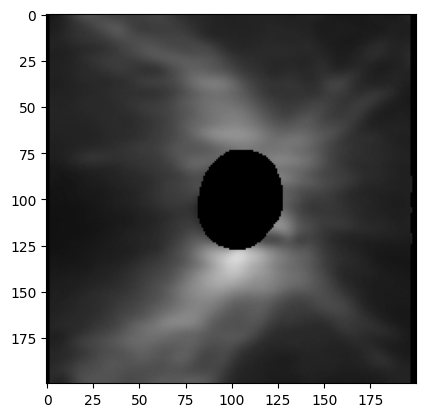

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

# you can have a look of some examples here
npz = np.load(
    "/media/SSD2/Dataset/GF3300/Training/data_0155.npz", allow_pickle=True)
print(list(npz.keys()))
img = npz["rnflt"]

print(img.max())
print(img.min())

print(img.shape)

img = (img - (-2)) / (350 + 2) * 255
print(img.max())
print(img.min())

img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
# print(np.array(img).shape)

plt.imshow(img)